# Create sales prediction models using broadcast data and sales data provided by NS Shop, and then propose an optimal broadcast schedule for increasing sales


In [1]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.svm import SVC

mpl.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline
# 데이터 프레임 자리수 표기
# pd.options.display.float_format = '{:.5f}'.format

In [2]:
실적데이터1 = pd.read_excel(
    r'./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx', header=1)
시청률데이터1 = pd.read_excel(
    r'./01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx', header=1)
평가데이터1 = pd.read_excel(
    r'./02_평가데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx', header=1)
기온데이터1 = pd.read_excel(
    r'./01_제공데이터/기온.xlsx', header=0, encoding='euc-kr')
강수량데이터1 = pd.read_excel(
    r'./01_제공데이터/강수량.xlsx', header=0, encoding='euc-kr')
풍속데이터1 = pd.read_excel(
    r'./01_제공데이터/풍속.xlsx', header=0, encoding='euc-kr')
주가데이터1 = pd.read_csv(
    r'./01_제공데이터/주가데이터.csv', header=0)

# Data Cleaning

In [4]:
실적데이터=실적데이터1.copy()
시청률데이터=시청률데이터1.copy()
평가데이터=평가데이터1.copy()

# rename column
실적데이터.rename(columns={'노출(분)' : '노출'}, inplace=True)

# Handling Missing Value
# 1. Drop rows that sales prices are 0
실적데이터.취급액.fillna(0, inplace=True)

# 2. Replaces the Nan values in"노출"column with the value from the previous row 
실적데이터.노출.fillna(method='ffill', inplace=True)

실적데이터=실적데이터[실적데이터.방송일시<'2020-01-01']

# 주문량 = 취급액 / 판매단가 round(x[1]/x[0], 3) if x[0]!=0 else 0
실적데이터['주문량'] = (실적데이터.취급액/실적데이터.판매단가).fillna(0)

# Make new columns with the specific dates and time
실적데이터['월']=실적데이터.방송일시.dt.month
실적데이터['일']=실적데이터.방송일시.dt.day
실적데이터['요일']=실적데이터.방송일시.dt.weekday
실적데이터['주']=실적데이터.방송일시.dt.week
실적데이터['시간']=실적데이터.방송일시.dt.time
실적데이터['시']=실적데이터.방송일시.dt.hour
실적데이터['분']=실적데이터.방송일시.dt.minute

# 실적데이터['시간'] = 실적데이터.시간.apply(lambda x : str(x)).apply(lambda x : int(x.split(':')[0])*60 + int(x.split(':')[1]))

실적데이터['방송날짜'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])
실적데이터['방송시간'] = 실적데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:-3])

# Adding external data

Wheather data

In [3]:
# Weather data cleaning
기온데이터=기온데이터1[['일시','평균최고기온(℃)', '평균최저기온(℃)']] #'평균기온(℃)',
강수량데이터=강수량데이터1[['일시','평균일강수량(mm)']] # ,'최다일강수량(mm)', '1시간최다강수량(mm)'
풍속데이터=풍속데이터1[['일시','최대풍속(m/s)']] # ,'평균풍속(m/s)', '최대순간풍속(m/s)'

기온데이터=기온데이터.sort_values(by='일시')
강수량데이터=강수량데이터.sort_values(by='일시')
풍속데이터=풍속데이터.sort_values(by='일시')

기온데이터.index=list(range(365))
강수량데이터.index=list(range(365))
풍속데이터.index=list(range(365))

기온데이터.일시=기온데이터.일시.map(lambda x : str(x).split(" ")[0])
강수량데이터.일시=강수량데이터.일시.map(lambda x : str(x).split(" ")[0])
풍속데이터.일시=pd.to_datetime(풍속데이터.일시).map(lambda x : str(x).split(" ")[0])

강수량데이터.fillna(0, inplace=True)

In [7]:
실적데이터 = 실적데이터.drop(['방송시간'],axis=1)
실적데이터=실적데이터.rename(columns={'방송날짜':'일시'})

실적데이터=pd.merge(실적데이터, 기온데이터, on='일시')
실적데이터=pd.merge(실적데이터, 강수량데이터, on='일시')
실적데이터=pd.merge(실적데이터, 풍속데이터, on='일시')

Viewership data

In [5]:
# Viewership data cleaning
시청률데이터.set_index('시간대', inplace=True)
시청률데이터.rename(columns={'2019-01-01 to 2019-12-31' : '년평균'}, inplace=True)
시청률데이터.rename(index={'월화수목금토일02:00-01:59' : '일평균'}, inplace=True)
시청률데이터2 = 시청률데이터.loc[:"01:59",:"2019-12-31"]

In [6]:
# Calculate the average viewership rate per minute for each broadcast time
분당평균시청률=[]
for i in range(len(실적데이터)):
    시작=실적데이터.방송시간.iloc[i]
    종료=str(pd.to_datetime(실적데이터.방송시간.iloc[i])+datetime.timedelta(minutes=round(float(실적데이터.노출.iloc[i]),0)-1)).split(" ")[1][:-3]
    분당평균시청률.append((시청률데이터2[실적데이터.방송날짜.iloc[i]].loc[시작:종료].mean()))
    
분당최고시청률=[]
for i in range(len(실적데이터)):
    시작=실적데이터.방송시간.iloc[i]
    종료=str(pd.to_datetime(실적데이터.방송시간.iloc[i])+datetime.timedelta(minutes=round(float(실적데이터.노출.iloc[i]),0)-1)).split(" ")[1][:-3]
    분당최고시청률.append((시청률데이터2[실적데이터.방송날짜.iloc[i]].loc[시작:종료].max()))

# average minute-by-minute viewership rate
실적데이터['분당평균시청률']=분당평균시청률
실적데이터['분당최고시청률']=분당최고시청률

Company stock data

In [8]:
주가데이터 = 주가데이터1.sort_values(by = '날짜')

# Make a new list for 2019 data
a = []
for i in range(13):
    if i in [1, 3, 5, 7, 8, 10, 12]:
        for j in range(1, 32):
            if i < 10:
                s1 = '0'+ str(i)
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))
    elif i in [4, 6, 9, 11]:
        for j in range(1, 31):
            if i < 10:
                s1 = '0'+ str(i) 
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))
    elif i == 2:
        for j in range(1, 29):
            if i < 10:
                s1 = '0'+ str(i) 
            else:
                s1 = str(i)
            if j < 10:
                s2 = '0'+ str(j)
            else:
                s2 = str(j)
            a.append("2019년 {}월 {}일".format(s1, s2))

# Fill in the missing dates in the stock data by merging with a list 
a=pd.DataFrame(a)
a.columns=['날짜']
주가데이터2 = pd.merge(주가데이터, a, on='날짜', how='outer')
주가데이터2 = 주가데이터2.sort_values(by='날짜')

# Filling missing data
주가데이터2 = 주가데이터2.fillna(method = 'ffill')
주가데이터2 = 주가데이터2.fillna(method = 'bfill')

# Calculating trading volume
주가데이터2.거래량=주가데이터2.거래량.map(lambda x : x[:-1])
주가데이터2.거래량=pd.to_numeric(주가데이터2.거래량)
주가데이터2.거래량=주가데이터2.거래량*1000

temp = pd.concat([실적데이터.pivot_table(index=['월','일'], values='주문량', aggfunc='mean').reset_index(), 주가데이터2.종가], axis=1)
temp.종가 = pd.to_numeric(temp.종가.map(lambda X: X.replace(",","")))

temp.drop(['주문량'], axis=1, inplace=True)

실적데이터=pd.merge(실적데이터, temp, on=['월','일'], how='outer')

# creating derived variables

In [10]:
# Weekend, Weekdays 
실적데이터['주말']=실적데이터.요일.map(lambda x :1 if x in [5,6] else 0)
실적데이터['수목금토']=실적데이터.요일.map(lambda x :1 if x in [2,3,4,5] else 0)

# Date
실적데이터['월말초'] = 실적데이터.일.map(lambda X: X in [1,2,3,4,5,6,26,27,28,29,30,31]).map(lambda X: 1 if X else 0)
실적데이터['26-28']=실적데이터.일.map(lambda x :1 if x in [26,27,28] else 0)

# Compare the trends of average orders by product category for each time slot,
# Creating new columns - night/early morning(19-02), Morning(6-12), Afternoon(12-19) 
실적데이터['밤/새벽(19-02)']=실적데이터.시.map(lambda x : 1 if x <= 2 or x >= 19 else 0)
실적데이터['오전(6-12)']=실적데이터.시.map(lambda x : 1 if 6 <= x <= 12 else 0)
실적데이터['오후(12-19)']=실적데이터.시.map(lambda x : 1 if 12 < x < 19 else 0)

# After 10-15,20
실적데이터['10-15,20이후']=실적데이터.시.map(lambda x : 1 if 10 <= x <= 15 or x >= 20 else 0)

# Divide into 3-hour intervals
실적데이터['0-2시']=실적데이터.시.map(lambda x : 1 if 0 <= x < 3 else 0)
실적데이터['3-5시']=실적데이터.시.map(lambda x : 1 if 3 <= x < 5 else 0)
실적데이터['6-8시']=실적데이터.시.map(lambda x : 1 if 6 <= x < 9 else 0)
실적데이터['9-11시']=실적데이터.시.map(lambda x : 1 if 9 <= x < 12 else 0)
실적데이터['12-14시']=실적데이터.시.map(lambda x : 1 if 12 <= x < 15 else 0)
실적데이터['15-17시']=실적데이터.시.map(lambda x : 1 if 15 <= x < 18 else 0)
실적데이터['18-20시']=실적데이터.시.map(lambda x : 1 if 18 <= x < 21 else 0)
실적데이터['21-23시']=실적데이터.시.map(lambda x : 1 if 21 <= x < 24 else 0)

#  7,8,9, 15-18
실적데이터['789,15-18']=실적데이터.시.map(lambda x :  1 if x in [7,8,9,15,16,17,18] else 0)

# 6 to 21
실적데이터['6-21시']=실적데이터.시.map(lambda x : 1 if 6 <= x < 22 else 0)

# 15-17
실적데이터['15-17시']=실적데이터.시.map(lambda x : 1 if 15 <= x < 18 else 0)

# Season
실적데이터['봄']=실적데이터.월.map(lambda x : 1 if x in [3,4,5] else 0)
실적데이터['여름']=실적데이터.월.map(lambda x :  1 if x in [6,7,8] else 0)
실적데이터['가을']=실적데이터.월.map(lambda x :  1 if x in [9,10,11] else 0)
실적데이터['겨울']=실적데이터.월.map(lambda x :  1 if x in [12,1,2] else 0)

# first half / Second half of the year
실적데이터['상반기']=실적데이터.월.map(lambda x : 1 if  x in [1,2,3,4,5,6] else 0)

실적데이터['월789']=실적데이터.월.map(lambda x :  1 if x in [7,8,9] else 0)

실적데이터['월6-10']=실적데이터.월.map(lambda x :  1 if x in [6,7,8,9,10] else 0)
실적데이터['월11-12']=실적데이터.월.map(lambda x :  1 if x in [11,12] else 0)

# Total broadcast duration
실적데이터['노출20미만']=실적데이터.노출.map(lambda x : 1 if x < 20 else 0)
실적데이터['노출20이상']=실적데이터.노출.map(lambda x : 1 if 20 <= x < 30 else 0)
실적데이터['노출30이상']=실적데이터.노출.map(lambda x : 1 if x >= 30 else 0)

# total week
실적데이터['주32이상']=실적데이터.주.map(lambda x : 1 if x >= 32 else 0)

# Total time
실적데이터['168시간기준']=실적데이터.방송일시.dt.weekday*24+실적데이터.방송일시.dt.hour

In [104]:
# Company brand columns

# Droping unnecessary words in the product names 
list1 = []
for item in 실적데이터[['상품명']].values:
    for i in ['(직매입)', '일시불', '무이자', '도냄', 'a4', '뉴', '(일)', '(무)', '특집', '(쿠)',
              '초특가''(세일20%)', '1세트', '2세트', '(더블+더블)', '(더블+싱글)', '(더블사이즈)', 
              '(싱글사이즈)', '(점보특대형)', '(점보형)', '(중형)', '(퀸+퀸)', '(퀸+싱글)', '(싱글+싱글)', 
              '(킹사이즈)', '(퀸사이즈)', '[완벽더블]', '파격가', '초특가', '무)', '(렌탈)', '국내산']:
        item[0] = item[0].replace(i, "")
    list1.append(item[0].strip())

# Delete every character except for number, English, Korean
list3 = []
for i in list1:
    result_string = ""
    for c in i:
        if c == " ":
            result_string += c
        elif c.isalnum():
            result_string += c
    list3.append(result_string.strip())

# Most product name starts with the brand name. Therefore extract the first word and made brand columns
list4 = []
for item in list3:
    list4.append(item.split(" ")[0])
실적데이터['브랜드'] = pd.Series(list4)

# Calculate brand score
# Brand average orders
df_temp = 실적데이터.pivot_table(
    index=['브랜드'], values='주문량', aggfunc='count').sort_values(by='주문량', ascending=False)
# Adjust the scale to between 0 and 1 using MinMaxScaler
df_temp1 = pd.DataFrame(
    MinMaxScaler().fit_transform(df_temp), index=df_temp.index)

# Calculate the brand score by adjusting the average order for each brand using scaling, and create a column for brand score
df_temp1 = df_temp1.reset_index()
실적데이터 = pd.merge(실적데이터, df_temp1, on='브랜드')
실적데이터.rename({0: '브랜드점수'}, axis=1, inplace=True)

In [ ]:
# Graph
실적데이터.pivot_table(index=['브랜드'],values='주문량', aggfunc='mean').sort_values(by='주문량', ascending=False).plot(figsize=(15,10), kind='bar')

# One-Hot Encoding

In [105]:
실적데이터_feature = 실적데이터.drop(['주문량','취급액', '방송일시', '상품명', '일시','브랜드', '시간','분당평균시청률'], axis=1)
실적데이터_target= 실적데이터['주문량']

# Categories
상품군_df=pd.get_dummies(실적데이터_feature.상품군)
실적데이터_feature=pd.concat([실적데이터_feature, 상품군_df],axis=1)


# MotherCode/ProductCode
실적데이터_feature.마더코드=실적데이터_feature.마더코드-100000
실적데이터_feature.상품코드=실적데이터_feature.상품코드-200000

마더코드_df=pd.get_dummies(실적데이터_feature.마더코드)
마더코드=[]
마더코드_max=실적데이터_feature.마더코드.max()
마더코드1=[str(i)+"마더코드" for i in range(0,마더코드_max+1)]
for i in 마더코드_df.columns:
    마더코드.append(str(i)+'마더코드')
마더코드_df.columns=마더코드
for i in [item for item in 마더코드1 if item not in 마더코드]:
    마더코드_df[i]=[0 for i in range(38300)]
마더코드_df=마더코드_df[마더코드1]
실적데이터_feature=pd.concat([실적데이터_feature, 마더코드_df],axis=1)

상품코드_df=pd.get_dummies(실적데이터_feature.상품코드)
상품코드=[]
상품코드_max=실적데이터_feature.상품코드.max()
상품코드1=[str(i)+"상품코드" for i in range(0,상품코드_max+1)]
for i in 상품코드_df.columns:
    상품코드.append(str(i)+'상품코드')
상품코드_df.columns=상품코드
for i in [item for item in 상품코드1 if item not in 상품코드]:
    상품코드_df[i]=[0 for i in range(38300)]
상품코드_df=상품코드_df[상품코드1]
실적데이터_feature=pd.concat([실적데이터_feature, 상품코드_df],axis=1)

# Month
월_df=pd.get_dummies(실적데이터_feature.월)
월=[]
월1=[str(i)+"월" for i in range(1,13)]
for i in 월_df.columns:
    월.append(str(i)+'월')
월_df.columns=월
for i in [item for item in 월1 if item not in 월]:
    월_df[i]=[0 for i in range(38300)]
월_df=월_df[월1]
실적데이터_feature=pd.concat([실적데이터_feature, 월_df],axis=1)

# Date
일_df=pd.get_dummies(실적데이터_feature.일)
일=[]
일1=[str(i)+'일' for i in range(1,32)]
for i in 일_df.columns:
    일.append(str(i)+'일')
일_df.columns=일
for i in [item for item in 일1 if item not in 일]:
    일_df[i]=[0 for i in range(38300)]
일_df=일_df[일1]
실적데이터_feature=pd.concat([실적데이터_feature, 일_df],axis=1)

#Day of the week
요일_df=pd.get_dummies(실적데이터_feature.요일)
요일=[]
요일1=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
for i in 요일_df.columns:
    요일.append(요일1[i])
요일_df.columns=요일
for i in [item for item in 요일1 if item not in 요일]:
    요일_df[i]=[0 for i in range(38300)]
요일_df=요일_df[요일1]
실적데이터_feature=pd.concat([실적데이터_feature, 요일_df],axis=1)

# Week
주_df=pd.get_dummies(실적데이터_feature.주)
주=[]
주1=[str(i)+"주" for i in range(1,53)]
for i in 주_df.columns:
    주.append(str(i)+'주')
주_df.columns=주
for i in [item for item in 주1 if item not in 주]:
    주_df[i]=[0 for i in range(38300)]
주_df=주_df[주1]
실적데이터_feature=pd.concat([실적데이터_feature, 주_df],axis=1)

# Hour
시_df=pd.get_dummies(실적데이터_feature.시)
시=[]
시1=[str(i)+"시" for i in range(0,24)]
for i in 시_df.columns:
    시.append(str(i)+'시')
시_df.columns=시
for i in [item for item in 시1 if item not in 시]:
    시_df[i]=[0 for i in range(38300)]
시_df=시_df[시1]
실적데이터_feature=pd.concat([실적데이터_feature, 시_df],axis=1)

# Minute
분_df=pd.get_dummies(실적데이터_feature.분)
분=[]
분1=[str(i)+"분" for i in range(0,60,5)]
for i in 분_df.columns:
    분.append(str(i)+'분')
분_df.columns=분
for i in [item for item in 분1 if item not in 분]:
    분_df[i]=[0 for i in range(38300)]
분_df=분_df[분1]
실적데이터_feature=pd.concat([실적데이터_feature, 분_df],axis=1)

# Other data scaling
실적데이터_feature.판매단가=실적데이터_feature.판매단가/100000
실적데이터_feature.종가=실적데이터_feature.종가/10000
실적데이터_feature.노출=실적데이터_feature.노출/60


필요없는 컬럼 삭제

In [148]:
# Data Cleaning - Drop unnecessary columns
실적데이터_feature.drop(['마더코드', '상품코드', '월', '일', '요일', '주' , '시', '분','상품군'], axis=1, inplace=True)
# X.drop(['브랜드점수'], axis=1, inplace=True)
실적데이터_feature.drop(['밤/새벽(19-02)','오전(6-12)','오후(12-19)'], axis=1)
실적데이터_feature.drop(['주말'], axis=1, inplace=True)
실적데이터_feature.drop(['노출20미만','노출20이상','노출30이상'], axis=1, inplace=True)
실적데이터_feature.drop(['평균최고기온(℃)', '평균최저기온(℃)', '평균일강수량(mm)', '최대풍속(m/s)'], axis=1, inplace=True) # 
실적데이터_feature.drop(['봄','여름','가을','겨울'], axis=1, inplace=True)
실적데이터_feature.drop(['상반기'], axis=1, inplace=True)
실적데이터_feature.drop(['월789'], axis=1, inplace=True)
실적데이터_feature.drop(['월6-10'], axis=1, inplace=True)
실적데이터_feature.drop(['월11-12'], axis=1, inplace=True)
실적데이터_feature.drop(['주32이상'], axis=1, inplace=True)
실적데이터_feature.drop(['월말초'], axis=1, inplace=True)
실적데이터_feature.drop(['26-28'], axis=1, inplace=True)
실적데이터_feature.drop(['10-15,20이후'], axis=1, inplace=True)
실적데이터_feature.drop(['0-2시'], axis=1, inplace=True)
실적데이터_feature.drop(['3-5시'], axis=1, inplace=True)
실적데이터_feature.drop(['6-8시'], axis=1, inplace=True)
실적데이터_feature.drop(['9-11시'], axis=1, inplace=True)
실적데이터_feature.drop(['12-14시'], axis=1, inplace=True)
실적데이터_feature.drop(['15-17시'], axis=1, inplace=True)
실적데이터_feature.drop(['18-20시'], axis=1, inplace=True)
실적데이터_featureX.drop(['21-23시'], axis=1, inplace=True)
실적데이터_feature.drop(['789,15-18'], axis=1, inplace=True)
실적데이터_feature.drop(['6-21시'], axis=1, inplace=True)
실적데이터_feature.drop(['168시간기준'], axis=1, inplace=True)
실적데이터_feature.drop(['수목금토'], axis=1, inplace=True)
실적데이터_feature.drop(['분당최고시청률'], axis=1, inplace=True)
실적데이터_feature적데이터_feature.drop(['종가'], axis=1, inplace=True)

In [135]:
X=실적데이터_feature.copy()
y=실적데이터_target.copy()

# Graph analysis to create derived variables

Compare the order volume per product category by hour with the number of broadcasts

In [100]:
상품별_주문량_시=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='mean')
상품별_갯수_시=실적데이터.pivot_table(index=['시'],columns='상품군',values='주문량', aggfunc='count')

In [110]:
상품별_주문량_시.fillna(0, inplace=True)
상품별_갯수_시.fillna(0, inplace=True)

In [239]:
temp1=상품별_주문량_시.loc[6:23]
temp2=상품별_주문량_시.loc[0:2]
상품별_주문량_시=pd.concat([temp1,temp2], axis=0)

In [246]:
temp1=상품별_갯수_시.loc[6:23]
temp2=상품별_갯수_시.loc[0:2]
상품별_갯수_시=pd.concat([temp1,temp2], axis=0)

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


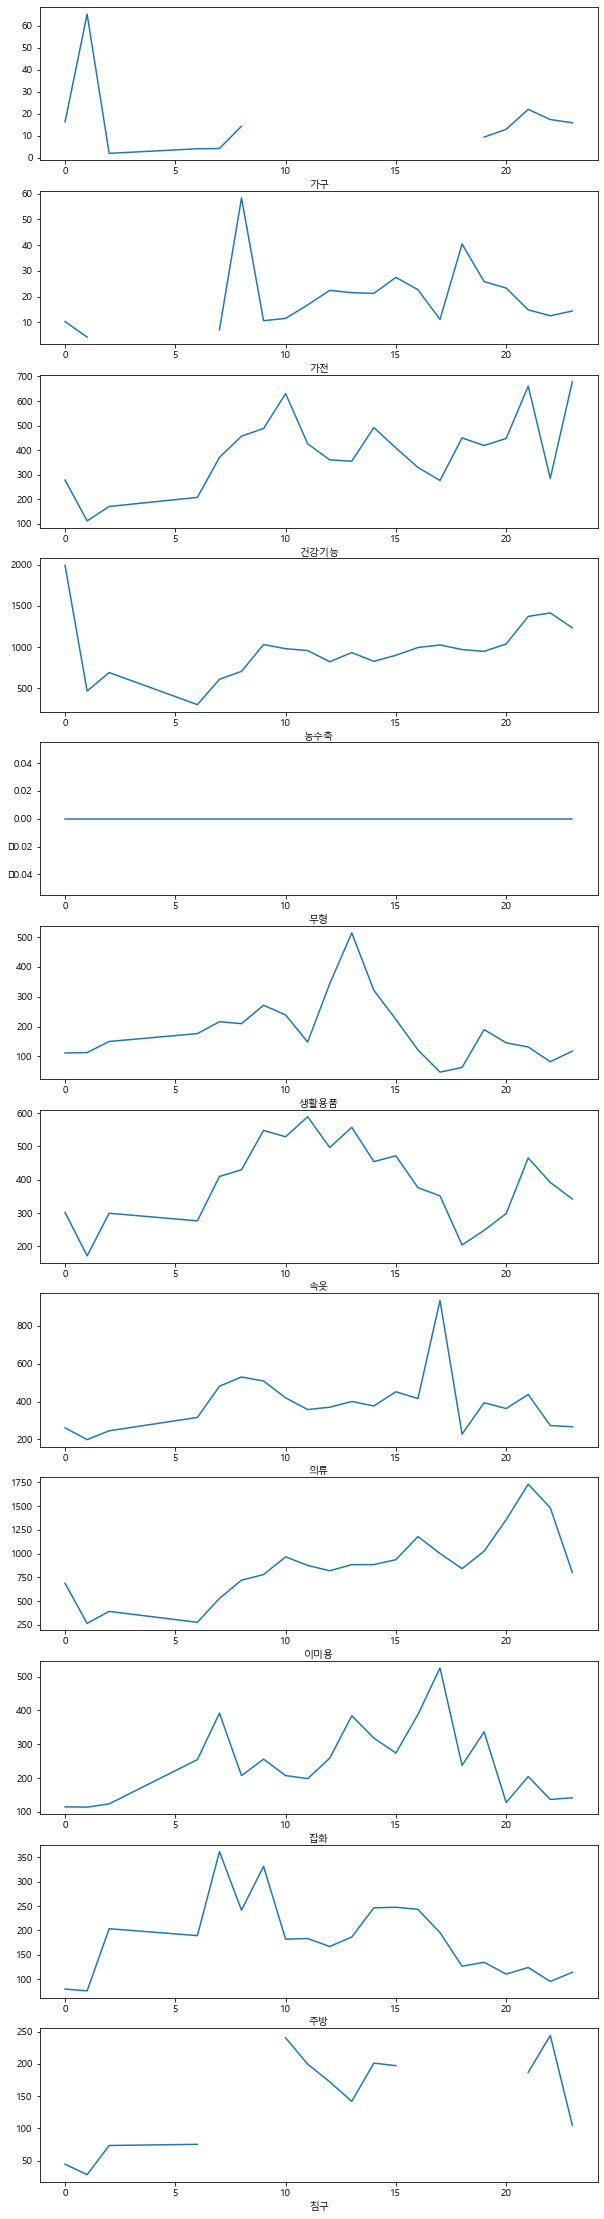

In [103]:
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_주문량_시.columns)):
    plt.subplot(12,1,i+1)
    상품별_주문량_시[item].plot(kind='bar')
    plt.xlabel(item)
plt.savefig('상품별 시간별 평균 주문량.png')

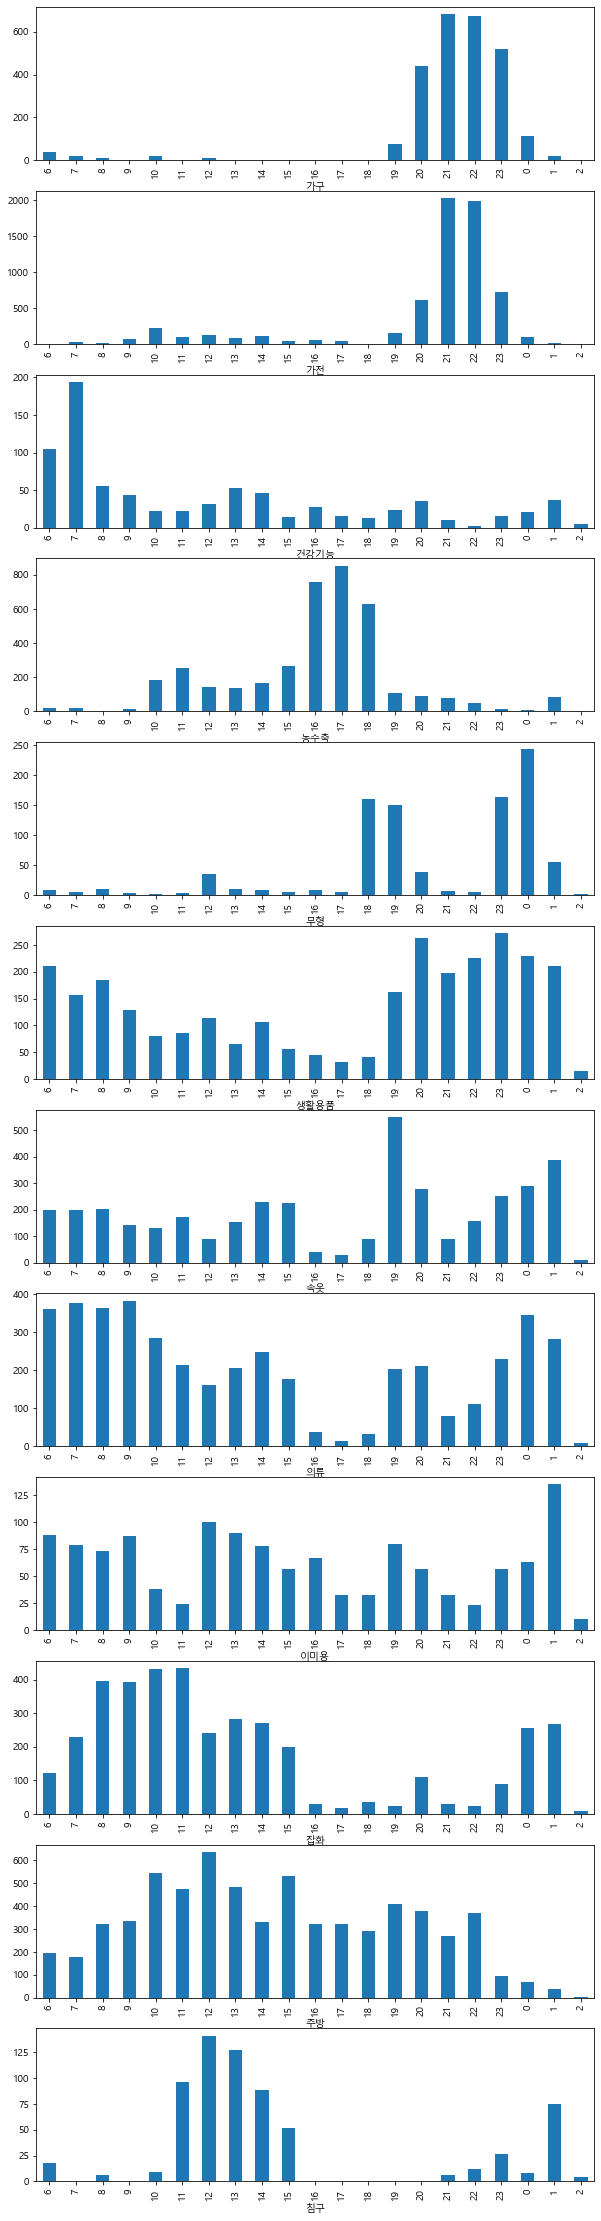

In [248]:
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_갯수_시.columns)):
    plt.subplot(12,1,i+1)
    상품별_갯수_시[item].plot(kind='bar')
    plt.xlabel(item)
plt.savefig('상품군별 시간별 방송횟수.png')

G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
G:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


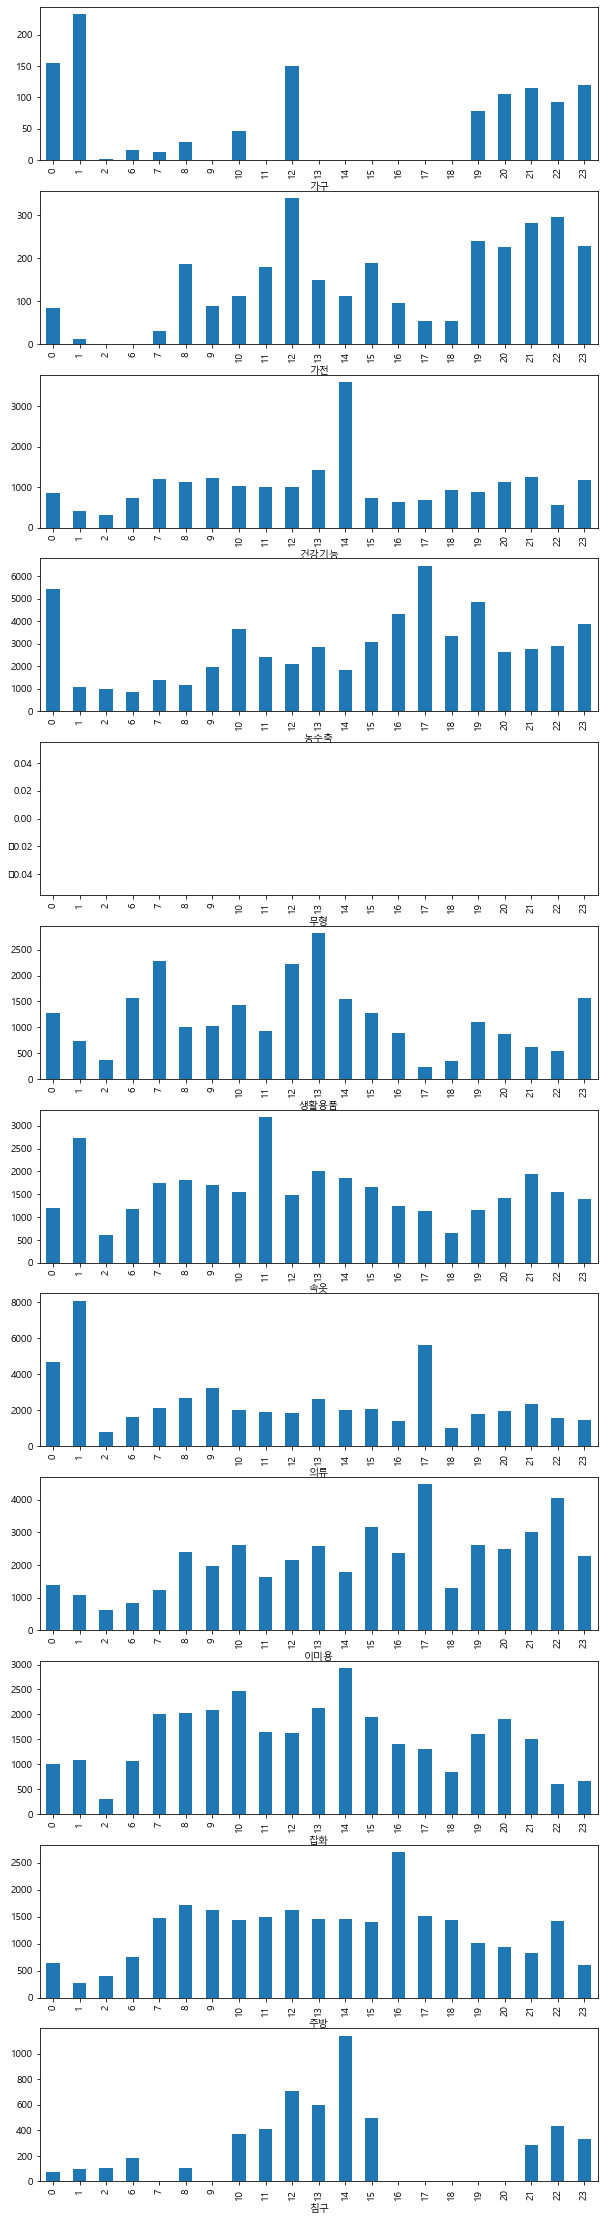

In [122]:
plt.figure(figsize=(10,40))
for i, item in enumerate(list(상품별_주문량_시_max.columns)):
    plt.subplot(12,1,i+1)
    상품별_주문량_시_max[item].plot(kind='bar')
    plt.xlabel(item)

Compare the order volume by product category for each day of the week

In [209]:
상품별_주문량_요일=실적데이터.pivot_table(index=['요일'],columns='상품군',values='주문량', aggfunc='mean')
상품별_주문량_요일.fillna(0, inplace=True)

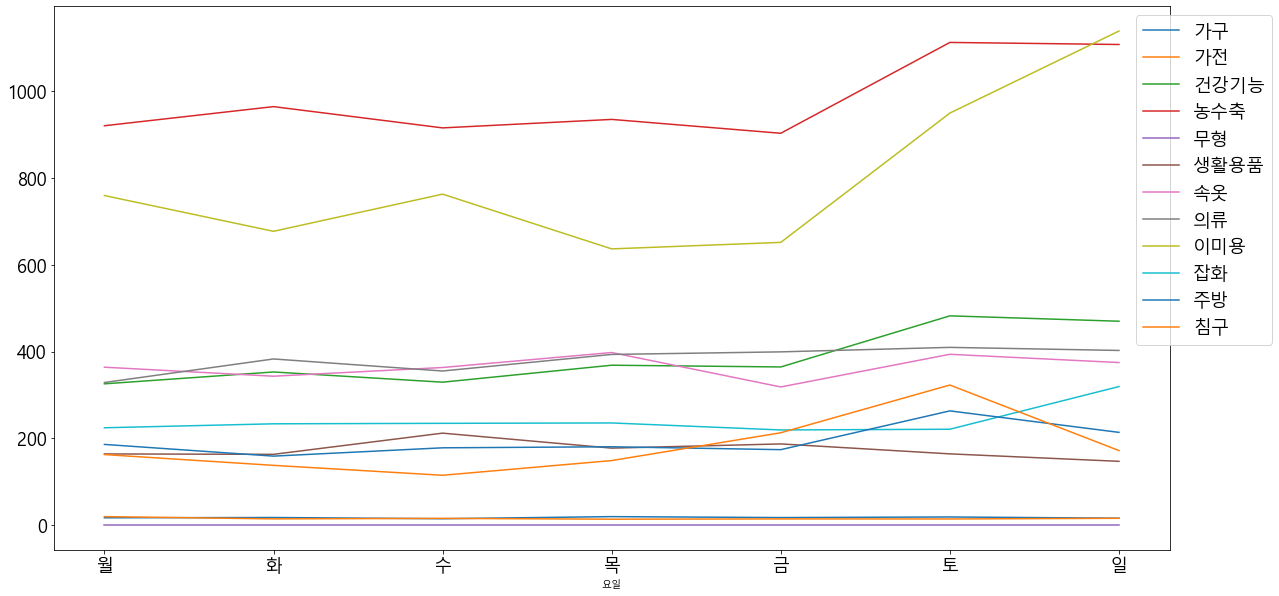

In [235]:
# for i, item in enumerate(list(상품별_주문량_요일.columns)):
#     plt.subplot(12,1,i+1)
상품별_주문량_요일.plot(kind='line',figsize=(20,10), fontsize=18)
# plt.xlabel(상품별_주문량_요일.index)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=18)
plt.xticks([0,1,2,3,4,5,6],['월','화','수','목','금','토','일'])
plt.savefig('상품군별 요일별 평균 주문량.png')

# Making Prediction Models

### XGBOOST

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)

xgb_reg = XGBRegressor(n_estimator = 500, gamma=0, learning_rate=0.4, max_depth=10, n_jobs=-1, objective ='reg:squarederror')
# xgb_reg = XGBClassifier(n_estimator = 1000)

xgb_reg.fit(X_train, y_train) # early_stopping_rounds=200,
         # eval_set = [(X_test, y_test)], eval_metric='logloss')

0.8821755113590134

In [171]:
y_pred=xgb_reg.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

r2 :  0.9998104718255412
[3.0308556e+01 3.9818762e+02 3.5153281e+02 ... 7.8018584e+00 6.9154071e+02
 2.1347135e-02]


## Multi-layer Perceptron

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_states=1)
mlp = MLPRegressor(hidden_layer_sizes=(10,10,10), max_iter=200, solver='adam', objective ='reg:squarederror')
mlp.fit(X_train, y_train)

G:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[  68.9957217   506.73024355  813.11448224 ...   23.17368063   26.96283346
 1519.95966321]
24982.018404709623 158.05700998282114 0.861196545569298


In [ ]:
y_pred = mlp.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

##  Neural Network

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

n=X_train.shape[1:]
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=n, kernel_initializer='normal'),
    keras.layers.Dense(16, activation='relu', kernel_initializer='normal'),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])
model.summary()

In [279]:
history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2, verbose=1)

Epoch 1/30
2298/2298 [==============================] - 5s 2ms/step - loss: 96364.3906 - mae: 166.6666 - val_loss: 46371.3203 - val_mae: 116.6744
Epoch 2/30
2298/2298 [==============================] - 5s 2ms/step - loss: 42250.5156 - mae: 104.5947 - val_loss: 36151.3789 - val_mae: 99.7440
Epoch 3/30
2298/2298 [==============================] - 5s 2ms/step - loss: 35377.8359 - mae: 93.1552 - val_loss: 31679.4727 - val_mae: 93.2048
Epoch 4/30
2298/2298 [==============================] - 4s 2ms/step - loss: 32027.8926 - mae: 87.3788 - val_loss: 29308.4961 - val_mae: 88.1876
Epoch 5/30
2298/2298 [==============================] - 5s 2ms/step - loss: 30045.9844 - mae: 83.8594 - val_loss: 28600.7891 - val_mae: 85.8380
Epoch 6/30
2298/2298 [==============================] - 5s 2ms/step - loss: 28640.1289 - mae: 80.9122 - val_loss: 27463.6875 - val_mae: 83.6098
Epoch 7/30
2298/2298 [==============================] - 5s 2ms/step - loss: 27679.0996 - mae: 78.1742 - val_loss: 26126.3965 - val_ma

In [43]:
loss_and_metrics = model.evaluate(X_test, y_test)
print(f'\nLoss : {loss_and_metrics[0]:6}')
print(f'mae : {loss_and_metrics[1]:6}')

Epoch 1/30
2298/2298 [==============================] - 4s 2ms/step - loss: 100297.6328 - mae: 169.6360 - val_loss: 48170.9336 - val_mae: 113.0840
Epoch 2/30
2298/2298 [==============================] - 3s 1ms/step - loss: 43096.2539 - mae: 101.6528 - val_loss: 36111.3945 - val_mae: 93.9481
Epoch 3/30
2298/2298 [==============================] - 4s 2ms/step - loss: 35498.1641 - mae: 88.6779 - val_loss: 31341.4570 - val_mae: 86.7336
Epoch 4/30
2298/2298 [==============================] - 3s 1ms/step - loss: 31759.6016 - mae: 82.1066 - val_loss: 29258.8672 - val_mae: 83.5114
Epoch 5/30
2298/2298 [==============================] - 3s 2ms/step - loss: 29747.9160 - mae: 78.0564 - val_loss: 27703.2070 - val_mae: 81.6629
Epoch 6/30
2298/2298 [==============================] - 3s 1ms/step - loss: 28458.9766 - mae: 75.6777 - val_loss: 26712.9688 - val_mae: 80.0622
Epoch 7/30
2298/2298 [==============================] - 3s 1ms/step - loss: 27462.4160 - mae: 73.6180 - val_loss: 26080.4590 - val_m

In [47]:
y_pred=model.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

0.90033613665942

## GridSearchCV

In [674]:
mlp = MLPRegressor(solver='adam', objective ='reg:squarederror')
mlp_params={
    'hidden_layer_sizes' : [(10,10,10),(100,100,100),(200,200,200)],
    'max_iter' : [100,200,300]
}

In [175]:
XGBReg=XGBRegressor( n_jobs=-1, objective ='reg:squarederror')
XGB_params={
    'n_estimator' : [100,300,500], 'gamma':[0,0.1,0.2], 'learning_rate':[0.3,0.4,0.5], 'max_depth':[5,10,15]
}

In [176]:
grid_rf = GridSearchCV(XGBReg, param_grid=XGB_params, cv = 5)
# grid_rf = GridSearchCV(mlp, param_grid=mlp_params, cv = 5)

In [177]:
grid_rf.fit(X_train, y_train)

[18:20:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:20:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:21:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.8635913179099051

In [182]:
y_pred=grid_rf.predict(X_test)
mse = mt.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = mt.r2_score(y_test, y_pred)
print(mse, rmse, r2)

학습데이터 정확도  0.9894742456727855
테스트데이터 정확도 0.86


In [191]:
grid_rf.best_estimator_

XGBRegressor(gamma=0.1, learning_rate=0.3, max_depth=10, n_estimator=100,
             n_jobs=-1)

## KNN


In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors = 12, weights = "distance")
knn_reg.fit(X_train, y_train)

y_pred = knn_reg.predict(X_test)

mt.r2_score(y_test, y_pred)

## Random Forest


In [ ]:
## 상품가격대 4등급으로 쪼갠 후 학습

상품가격 = pd.qcut(실적수치데이터.판매단가,4)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
상품가격대 = le.fit_transform(상품가격)

실적수치데이터['상품가격대'] = 상품가격대


from sklearn.model_selection import StratifiedShuffleSplit
shuffledSplit = StratifiedShuffleSplit(test_size = 0.3)
for train_idx, test_idx in shuffledSplit.split(실적수치데이터,실적수치데이터.상품가격대):
    train_set = 실적수치데이터.loc[train_idx]
    test_set = 실적수치데이터.loc[test_idx]
    
train_set.drop('상품가격대', axis=1, inplace = True)
test_set.drop('상품가격대', axis=1, inplace = True)


X_train = train_set.drop('주문량',axis=1)
y_train = train_set.주문량
X_test = test_set.drop('주문량',axis=1)
y_test = test_set.주문량

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
shuffledSplit = StratifiedShuffleSplit(test_size = 0.3)
for train_idx, test_idx in shuffledSplit.split(정규화데이터,정규화데이터.월):
    train_set = 정규화데이터.loc[train_idx]
    test_set = 정규화데이터.loc[test_idx]
    
train_set.drop('상품가격대', axis=1, inplace = True)
test_set.drop('상품가격대', axis=1, inplace = True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV #최적화를 위해
import sklearn.metrics as mt
# randomforest
rf_reg = RandomForestRegressor().fit(X_train,y_train)
#학습
#rf_reg.fit(X_train,y_train)
y_pred = rf_reg.predict(X_test)

print(rf_reg.score(X_test, y_test))
print(mt.r2_score(y_test, y_pred))  

## k-fold cross validation

In [26]:
class nn_keras(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.data = None
        self.model = None
        self.result = None
        
    def fit(self, X_train, y_train):
        self.model = keras.models.Sequential([
                keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:], kernel_initializer='normal'),
                keras.layers.Dense(16, activation='relu', kernel_initializer='normal'),
                keras.layers.Dense(1)
            ])
        self.model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='mse', metrics=['mae'])
        self.result = self.model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2, verbose=1)
        
    def predict(self, new_data):
        return self.model.predict(new_data)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
cv = KFold(5, shuffle=True, random_state=0)
model=nn_keras()
results = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
print("Results: %.3f (%.3f) MAE" % (results.mean(), results.std()))
print(results)

Epoch 1/30
1839/1839 [==============================] - 4s 2ms/step - loss: 116961.7266 - mae: 187.0342 - val_loss: 56528.9023 - val_mae: 128.5258
Epoch 2/30
1839/1839 [==============================] - 3s 2ms/step - loss: 48864.7695 - mae: 111.5802 - val_loss: 42259.7266 - val_mae: 104.1155
Epoch 3/30
1839/1839 [==============================] - 3s 2ms/step - loss: 39618.6719 - mae: 95.5947 - val_loss: 36659.0898 - val_mae: 93.7485
Epoch 4/30
1839/1839 [==============================] - 3s 1ms/step - loss: 34946.8516 - mae: 87.1583 - val_loss: 33190.5977 - val_mae: 87.7217
Epoch 5/30
1839/1839 [==============================] - 3s 2ms/step - loss: 32211.4180 - mae: 82.1767 - val_loss: 31136.9570 - val_mae: 85.2730
Epoch 6/30
1839/1839 [==============================] - 3s 1ms/step - loss: 30458.7188 - mae: 78.7791 - val_loss: 29835.0215 - val_mae: 82.2786
Epoch 7/30
1839/1839 [==============================] - 3s 2ms/step - loss: 29304.6855 - mae: 76.5222 - val_loss: 29047.3535 - val_

# Predicte final data

In [66]:
# 데이터 전처리
평가데이터.rename(columns={'노출(분)' : '노출'}, inplace=True)

# 결측값 처리 
# 1. 판매단가가 0인 데이터 제거
평가데이터.취급액.fillna(0, inplace=True)

# 2. 노출값이 nan인 항목은 바로 위 항목으로 채우기
평가데이터.노출.fillna(method='ffill', inplace=True)

# 날짜 컬럼 나누기
평가데이터['월']=평가데이터.방송일시.dt.month
평가데이터['일']=평가데이터.방송일시.dt.day
평가데이터['요일']=평가데이터.방송일시.dt.weekday
평가데이터['주']=평가데이터.방송일시.dt.week
평가데이터['시간']=평가데이터.방송일시.dt.time
평가데이터['시']=평가데이터.방송일시.dt.hour
평가데이터['분']=평가데이터.방송일시.dt.minute

# 실적데이터['시간'] = 실적데이터.시간.apply(lambda x : str(x)).apply(lambda x : int(x.split(':')[0])*60 + int(x.split(':')[1]))

평가데이터['방송날짜'] = 평가데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[0])
평가데이터['방송시간'] = 평가데이터.방송일시.apply(lambda x : str(x)).apply(lambda x : x.split(' ')[1][:-3])

In [67]:
평가데이터 = 평가데이터.drop(['방송시간'],axis=1)
평가데이터=평가데이터.rename(columns={'방송날짜':'일시'})

In [116]:
# 브랜드 컬럼

# 상품명에서 불필요한 단어 제거
list1 = []
for item in 평가데이터[['상품명']].values:
    for i in ['(직매입)', '일시불', '무이자', '도냄', 'a4', '뉴', '(일)', '(무)', '특집', '(쿠)',
              '초특가''(세일20%)', '1세트', '2세트', '(더블+더블)', '(더블+싱글)', '(더블사이즈)', 
              '(싱글사이즈)', '(점보특대형)', '(점보형)', '(중형)', '(퀸+퀸)', '(퀸+싱글)', '(싱글+싱글)', 
              '(킹사이즈)', '(퀸사이즈)', '[완벽더블]', '파격가', '초특가', '무)', '(렌탈)', '국내산']:
        item[0] = item[0].replace(i, "")
    list1.append(item[0].strip())

# 숫자, 영어, 한글을 제외한 문자 제거
list3 = []
for i in list1:
    result_string = ""
    for c in i:
        if c == " ":
            result_string += c
        elif c.isalnum():
            result_string += c
    list3.append(result_string.strip())

# 주로 브랜드명이 첫 어절에 온다고 판단. 첫 어절로 브랜드 컬럼 생성
list4 = []
for item in list3:
    list4.append(item.split(" ")[0])
평가데이터['브랜드'] = pd.Series(list4)

# 브랜드별 점수 매기기
# 브랜드별 평균 주문량 계산
df_temp2 = 평가데이터.pivot_table(
    index=['브랜드'], values='판매단가', aggfunc='count').sort_values(by='판매단가', ascending=False)
# minmaxscaler로 0~1 사이값으로 scale 조정
df_temp3 = pd.DataFrame(
    MinMaxScaler().fit_transform(df_temp2), index=df_temp2.index)

# # 브랜드별 평균 주문량을 scale 조절한 값을 브랜드 점수로 산정. 브랜드점수 컬럼 생성
# df_temp1 = df_temp1.reset_index()
평가데이터 = pd.merge(평가데이터, df_temp1, on='브랜드')
평가데이터.rename({0: '브랜드점수'}, axis=1, inplace=True)

In [79]:
평가데이터_feature = 평가데이터.drop(['취급액', '방송일시', '상품명', '일시','브랜드','시간'], axis=1)
실적데이터_target= 실적데이터['주문량']

상품군_df=pd.get_dummies(평가데이터.상품군)
평가데이터=pd.concat([평가데이터, 상품군_df],axis=1)

평가데이터_feature.마더코드=평가데이터_feature.마더코드-100000
평가데이터_feature.상품코드=평가데이터_feature.상품코드-200000

마더코드_df=pd.get_dummies(평가데이터_feature.마더코드)
마더코드=[]
마더코드1=[str(i)+"마더코드" for i in range(0,마더코드_max+1)]
for i in 마더코드_df.columns:
    마더코드.append(str(i)+'마더코드')
마더코드_df.columns=마더코드
for i in [item for item in 마더코드1 if item not in 마더코드]:
    마더코드_df[i]=[0 for i in range(len(평가데이터_feature))]
마더코드_df=마더코드_df[마더코드1]
평가데이터_feature=pd.concat([평가데이터_feature, 마더코드_df],axis=1)

상품코드_df=pd.get_dummies(평가데이터_feature.상품코드)
상품코드=[]
상품코드1=[str(i)+"상품코드" for i in range(0,상품코드_max+1)]
for i in 상품코드_df.columns:
    상품코드.append(str(i)+'상품코드')
상품코드_df.columns=상품코드
for i in [item for item in 상품코드1 if item not in 상품코드]:
    상품코드_df[i]=[0 for i in range(len(평가데이터_feature))]
상품코드_df=상품코드_df[상품코드1]
평가데이터_feature=pd.concat([평가데이터_feature, 상품코드_df],axis=1)


월_df=pd.get_dummies(평가데이터_feature.월)
월=[]
월1=[str(i)+"월" for i in range(1,13)]
for i in 월_df.columns:
    월.append(str(i)+'월')
월_df.columns=월
for i in [item for item in 월1 if item not in 월]:
    월_df[i]=[0 for i in range(len(평가데이터_feature))]
월_df=월_df[월1]
평가데이터_feature=pd.concat([평가데이터_feature, 월_df],axis=1)

일_df=pd.get_dummies(평가데이터_feature.일)
일=[]
일1=[str(i)+'일' for i in range(1,32)]
for i in 일_df.columns:
    일.append(str(i)+'일')
일_df.columns=일
for i in [item for item in 일1 if item not in 일]:
    일_df[i]=[0 for i in range(len(평가데이터_feature))]
일_df=일_df[일1]
평가데이터_feature=pd.concat([평가데이터_feature, 일_df],axis=1)

요일_df=pd.get_dummies(평가데이터_feature.요일)
요일=[]
요일1=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
for i in 요일_df.columns:
    요일.append(요일1[i])
요일_df.columns=요일
for i in [item for item in 요일1 if item not in 요일]:
    요일_df[i]=[0 for i in range(len(평가데이터_feature))]
요일_df=요일_df[요일1]
평가데이터_feature=pd.concat([평가데이터_feature, 요일_df],axis=1)

주_df=pd.get_dummies(평가데이터_feature.주)
주=[]
주1=[str(i)+"주" for i in range(1,53)]
for i in 주_df.columns:
    주.append(str(i)+'주')
주_df.columns=주
for i in [item for item in 주1 if item not in 주]:
    주_df[i]=[0 for i in range(len(평가데이터_feature))]
주_df=주_df[주1]
평가데이터_feature=pd.concat([평가데이터_feature, 주_df],axis=1)

시_df=pd.get_dummies(평가데이터_feature.시)
시=[]
시1=[str(i)+"시" for i in range(0,24)]
for i in 시_df.columns:
    시.append(str(i)+'시')
시_df.columns=시
for i in [item for item in 시1 if item not in 시]:
    시_df[i]=[0 for i in range(len(평가데이터_feature))]
시_df=시_df[시1]
평가데이터_feature=pd.concat([평가데이터_feature, 시_df],axis=1)

분_df=pd.get_dummies(평가데이터_feature.분)
분=[]
분1=[str(i)+"분" for i in range(0,60,5)]
for i in 분_df.columns:
    분.append(str(i)+'분')
분_df.columns=분
for i in [item for item in 분1 if item not in 분]:
    분_df[i]=[0 for i in range(len(평가데이터_feature))]
분_df=분_df[분1]
평가데이터_feature=pd.concat([평가데이터_feature, 분_df],axis=1)


평가데이터_feature.판매단가=평가데이터_feature.판매단가/100000
평가데이터_feature.노출=평가데이터_feature.노출/60



평가데이터_feature = 평가데이터_feature.drop(['마더코드', '상품코드', '월', '일', '요일', '주' , '시', '분','상품군'], axis=1)

In [80]:
testX=평가데이터_feature.copy()
testy=평가데이터_target.copy()

In [83]:
# 학습 진행한 신경망 모델로 예측
y_pred=model.predict(testX)
평가데이터['주문량']=pd.DataFrame(y_pred, columns=['주문량'])
평가데이터['취급액']=평가데이터.주문량*평가데이터.판매단가

[[237.35516]
 [349.7268 ]
 [290.63193]
 ...
 [495.4551 ]
 [193.18962]
 [227.96466]]


In [274]:
# 평가데이터 예측취급액 넣어서 저장
평가데이터1.취급액=평가데이터.주문량*평가데이터1.판매단가
평가데이터1.to_csv('평가데이터_예측.csv', encoding='euc-kr')

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,1.419384e+07
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,2.091366e+07
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,1.737979e+07
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,3.146378e+07
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,3.875821e+07
...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,0.000000e+00
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,0.000000e+00
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,0.000000e+00
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,1.350395e+07


# Derive the optimal strategy for each day of the week, hour, and product category based on predictions

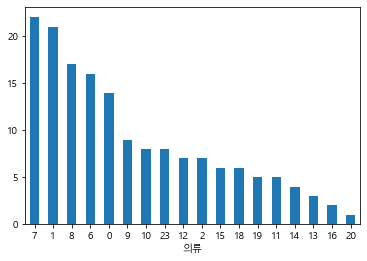

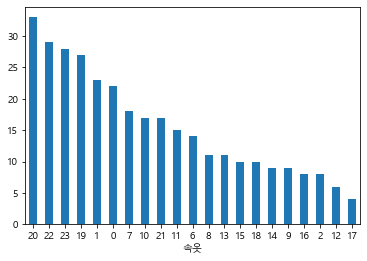

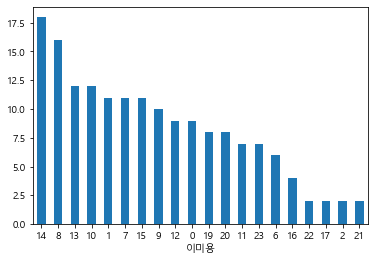

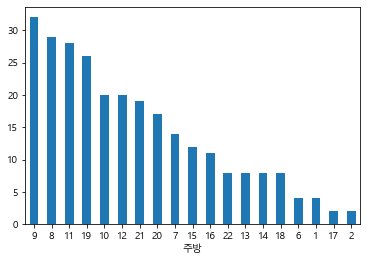

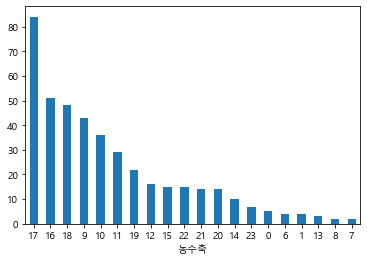

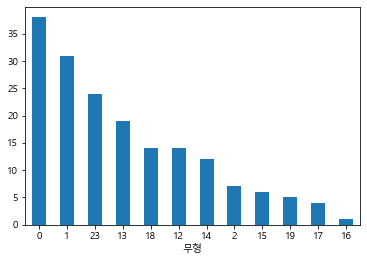

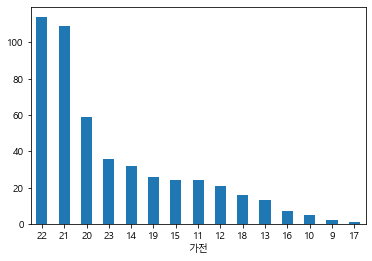

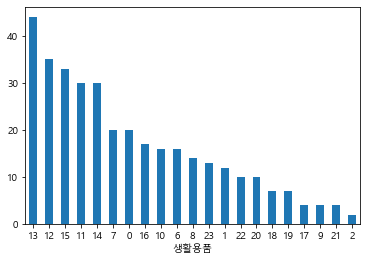

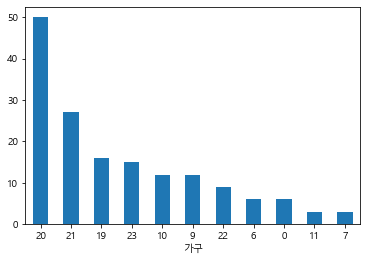

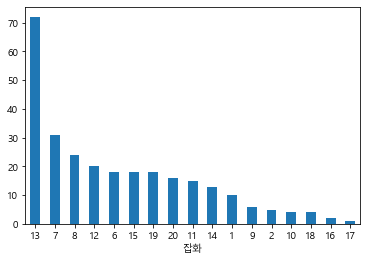

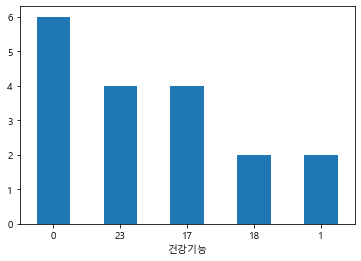

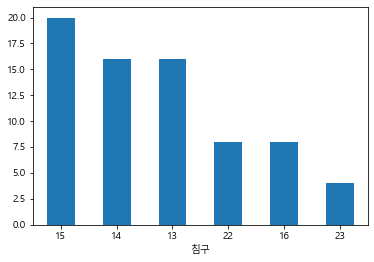

In [264]:
#for i in 평가데이터.상품군.unique():
ratio25 = int(len(평가데이터) * 0.25)
for item in 평가데이터.상품군.unique():
    plt.figure()
    평가데이터[평가데이터.상품군 == item].sort_values(by='취급액', ascending=False).시[:ratio25].value_counts().plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel(item)
    plt.savefig('data/{}시간.png'.format(item))

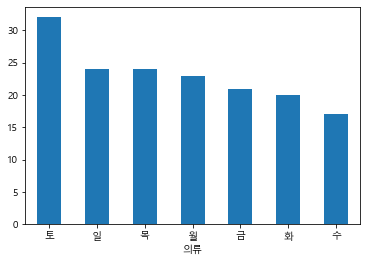

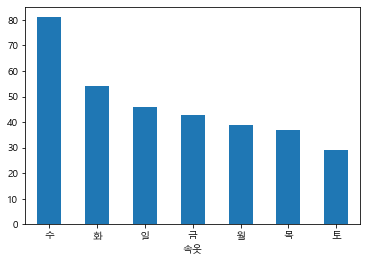

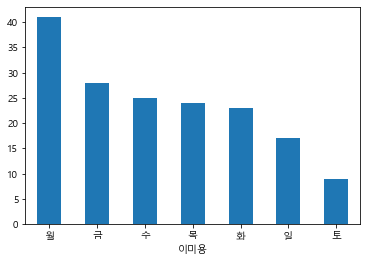

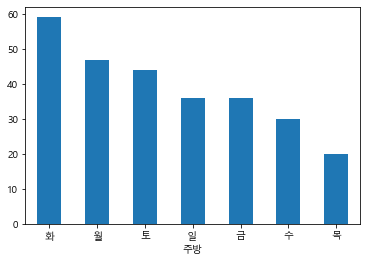

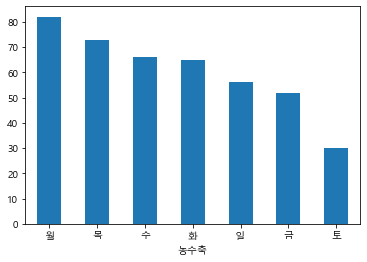

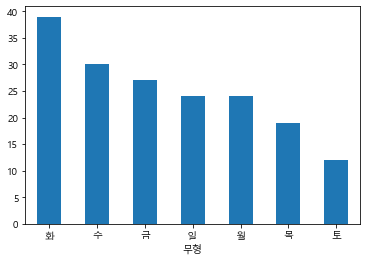

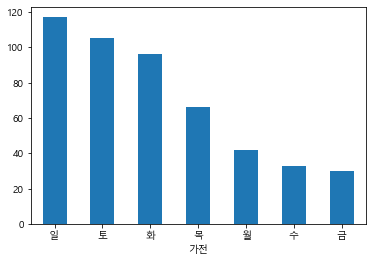

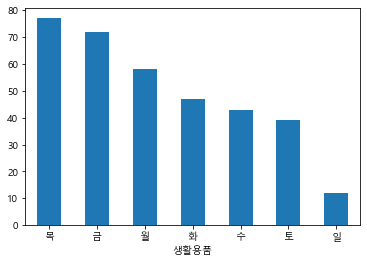

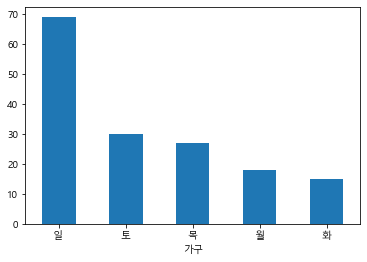

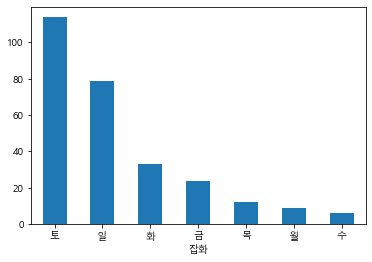

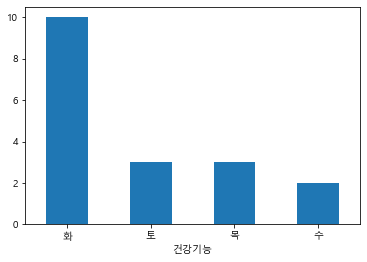

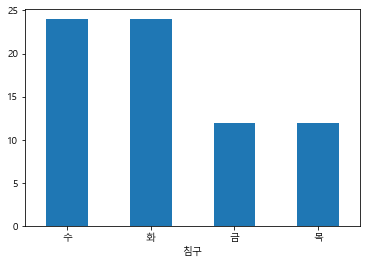

In [268]:
#for i in 평가데이터.상품군.unique():
ratio25 = int(len(평가데이터) * 0.25)
for item in 평가데이터.상품군.unique():
    plt.figure()
    temp=평가데이터[평가데이터.상품군 == item].sort_values(by='취급액', ascending=False).요일[:ratio25].value_counts()
    temp.rename({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'},axis=0,inplace=True)
    temp.plot(kind='bar')
    plt.xticks(rotation=0)
    plt.xlabel(item)
    plt.savefig('data/{}요일.png'.format(item))